In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA 
from time import time  # Only if you need to measure execution time



# CATFISH SALES DATA

In [74]:
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d')


In [75]:
catfish_sales = pd.read_csv('catfish.csv' , parse_dates=[0], index_col=0  , date_parser = parser)

C:\Users\user\AppData\Local\Temp\ipykernel_8732\2713199918.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  catfish_sales = pd.read_csv('catfish.csv' , parse_dates=[0], index_col=0  , date_parser = parser)


In [76]:
catfish_sales = catfish_sales.asfreq(pd.infer_freq(catfish_sales.index))

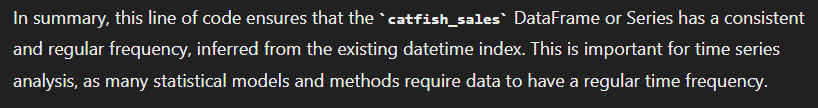

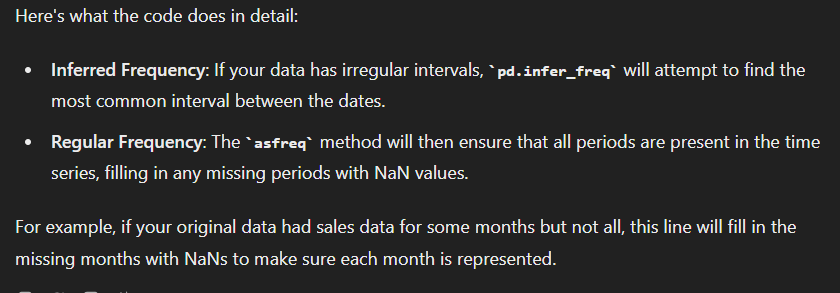

In [77]:
start_date = datetime(2000,1,1)
end_date = datetime(2004,1,1)

lim_catfish_sales = catfish_sales[start_date:end_date]



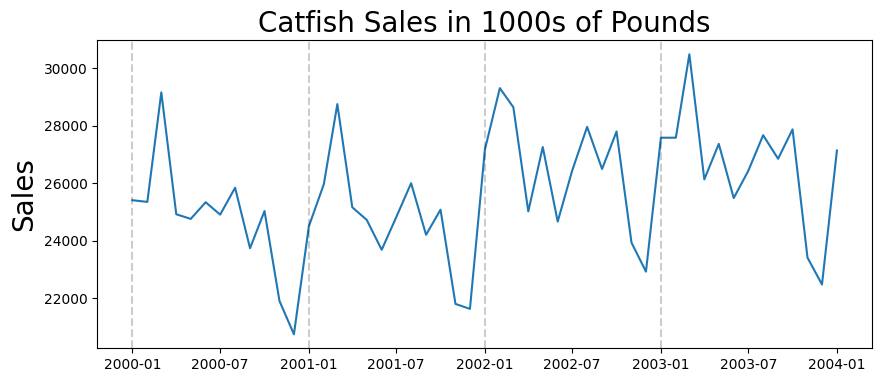

In [78]:
plt.figure(figsize = (10,4))
plt.plot(lim_catfish_sales)
plt.title('Catfish Sales in 1000s of Pounds' , fontsize = 20)
plt.ylabel('Sales' , fontsize = 20)

for year in range(start_date.year, end_date.year):
    plt.axvline(pd.to_datetime(str(year) + '-01-01'), color='k', linestyle='--', alpha = 0.2)
#plt.axhline(lim_catfish_sales.mean(), color='r', linestyle='--', alpha = 0.2)

The above graph looks like a non-stationary graph 

In [79]:
first_diff = lim_catfish_sales.diff()[1:]

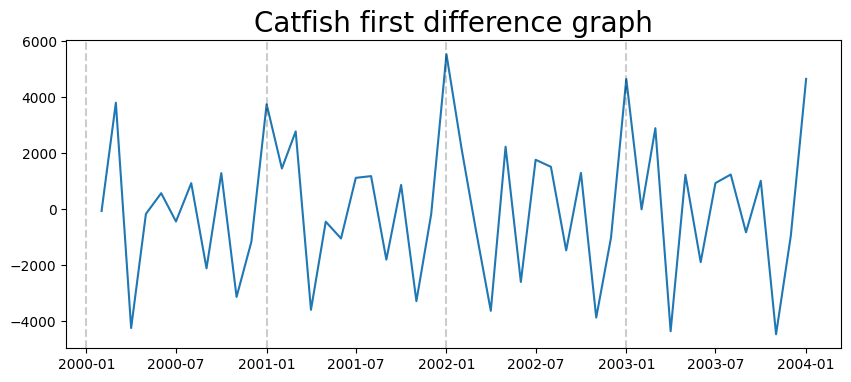

In [80]:
plt.figure(figsize=(10,4))

plt.plot(first_diff)

plt.title('Catfish first difference graph' , fontsize = 20)

for years in range(start_date.year , end_date.year):
    plt.axvline(pd.to_datetime(str(years) + '-01-01'), color='k', linestyle='--', alpha = 0.2)

ACF

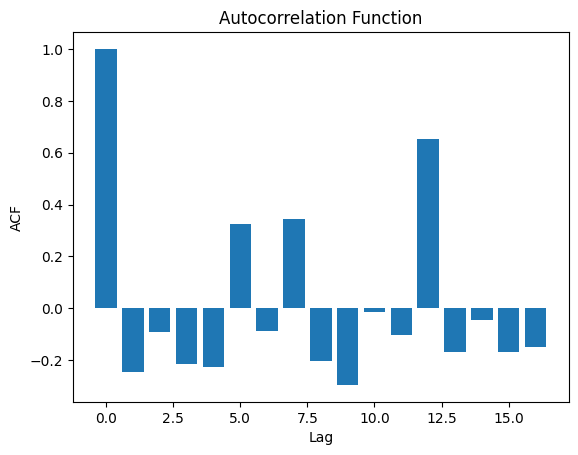

In [81]:
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf

# Compute the ACF values
acf_vals = acf(first_diff)

# Define the number of lags
num_lags = 20

# Ensure num_lags does not exceed the length of acf_vals
num_lags = min(num_lags, len(acf_vals))

# Plot the ACF values
plt.bar(range(num_lags), acf_vals[:num_lags])
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.title('Autocorrelation Function')
plt.show()


BASED ON ACF , WE SHOULD TAKE MA(1) process

PACF

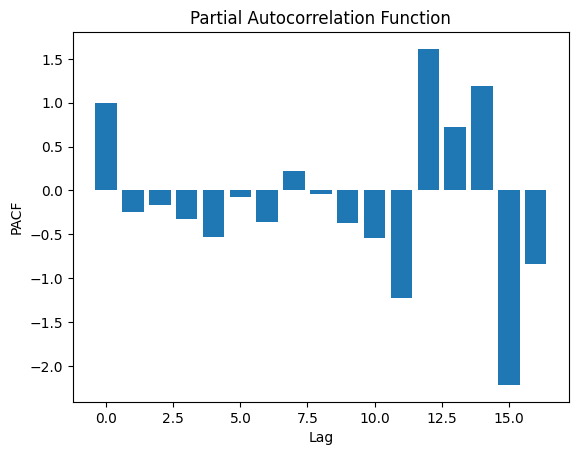

In [82]:
pacf_vals = pacf(first_diff)

# Define the number of lags
num_lags = 20

# Ensure num_lags does not exceed the length of acf_vals
num_lags = min(num_lags, len(pacf_vals))

# Plot the ACF values
plt.bar(range(num_lags), pacf_vals[:num_lags])
plt.xlabel('Lag')
plt.ylabel('PACF')
plt.title('Partial Autocorrelation Function')
plt.show()

BASED ON PACF, WE SHOULD START WITH A AR(4) PROCESS

Getting Training and Testing Sets 

In [83]:
train_end = datetime(2003,7,1)
test_end = datetime(2004, 1,1)

train_data = first_diff[:train_end]
test_data = first_diff[train_end + timedelta(days=1):test_end]

FIT THE ARIMA MODEL 

In [84]:
model = ARIMA(train_data, order=(4,1 , 1))


In [85]:
start = time()

model_fit = model.fit()

end = time()
print(end - start)


0.9719314575195312


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [86]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Total   No. Observations:                   42
Model:                 ARIMA(4, 1, 1)   Log Likelihood                -370.888
Date:                Sun, 07 Jul 2024   AIC                            753.776
Time:                        16:22:51   BIC                            764.058
Sample:                    02-01-2000   HQIC                           757.520
                         - 07-01-2003                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5044      0.137     -3.683      0.000      -0.773      -0.236
ar.L2         -0.3096      0.157     -1.977      0.048      -0.617      -0.003
ar.L3         -0.4701      0.217     -2.165      0.0

In [87]:
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]


In [88]:
predictions = model_fit.predict(start=pred_start_date, end=pred_end_date)

residuals = test_data - predictions

In [89]:
print(len(predictions))
print(len(test_data))

6
6


In [90]:


# Align the indices of test_data and predictions
predictions_aligned = predictions.reindex(test_data.index)

# Compute residuals
residuals = test_data['Total'] - predictions_aligned

# Print the results to debug
print("Test Data:")
print(test_data)
print("\nPredictions:")
print(predictions_aligned)
print("\nResiduals:")
print(residuals)





Test Data:
             Total
Date              
2003-08-01  1245.0
2003-09-01  -819.0
2003-10-01  1022.0
2003-11-01 -4459.0
2003-12-01  -934.0
2004-01-01  4658.0

Predictions:
Date
2003-08-01    1823.932937
2003-09-01    -870.612290
2003-10-01     473.681023
2003-11-01   -1221.400568
2003-12-01      34.536710
2004-01-01     664.229489
Freq: MS, Name: predicted_mean, dtype: float64

Residuals:
Date
2003-08-01    -578.932937
2003-09-01      51.612290
2003-10-01     548.318977
2003-11-01   -3237.599432
2003-12-01    -968.536710
2004-01-01    3993.770511
Freq: MS, dtype: float64


Text(0.5, 1.0, 'Residuals of ARIMA Model')

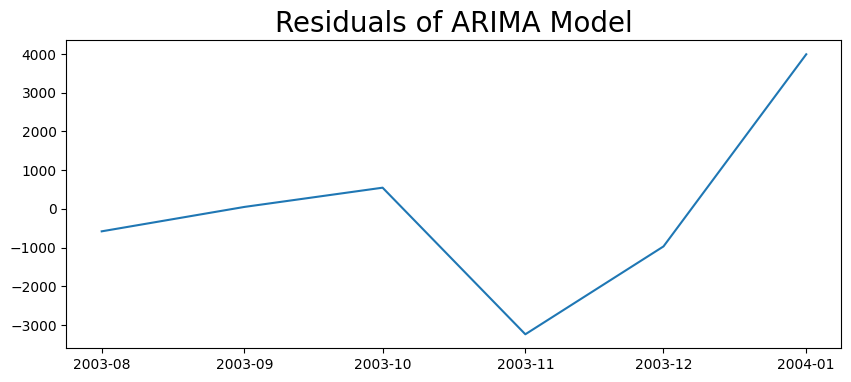

In [91]:
plt.figure(figsize=(10,4))

plt.plot(residuals)

plt.title('Residuals of ARIMA Model' , fontsize = 20)

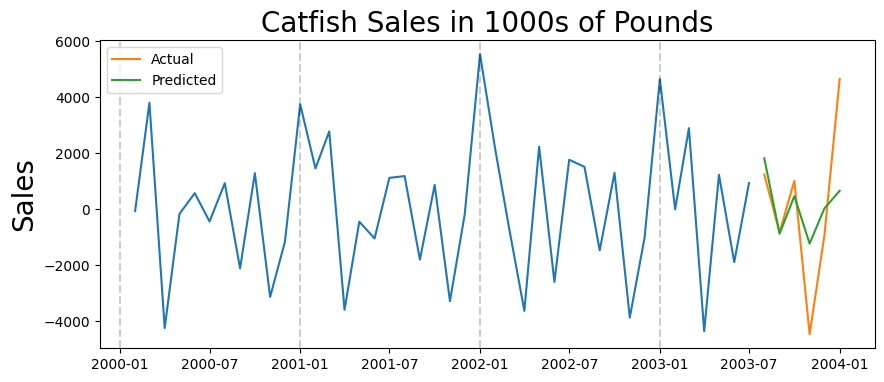

In [92]:
plt.figure(figsize=(10,4))

plt.plot(train_data)

plt.plot(test_data, label='Actual')

plt.plot(predictions_aligned, label='Predicted')

plt.title('Catfish Sales in 1000s of Pounds' , fontsize = 20)

plt.ylabel('Sales' , fontsize = 20)

plt.legend()

for year in range(start_date.year, end_date.year):
    plt.axvline(pd.to_datetime(str(year) + '-01-01'), color='k', linestyle='--', alpha = 0.2)


In [93]:
print(np.sqrt(np.mean(residuals**2)))

2160.586232397018


In [96]:
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [100]:
my_order = (4,1,1)

my_seasonal_order = (0,1,0,12)

model = SARIMAX(train_data , order = my_order , seasonal_order = my_seasonal_order)



In [101]:
start = time()
model_fit = model.fit()

end = time()

print(end - start)

0.41640734672546387


In [102]:
print(model_fit.summary())

                                      SARIMAX Results                                      
Dep. Variable:                               Total   No. Observations:                   42
Model:             SARIMAX(4, 1, 1)x(0, 1, [], 12)   Log Likelihood                -249.065
Date:                             Sun, 07 Jul 2024   AIC                            510.130
Time:                                     17:57:43   BIC                            518.334
Sample:                                 02-01-2000   HQIC                           512.699
                                      - 07-01-2003                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3634      0.237     -1.536      0.125      -0.827       0.100
ar.L2         -0.5652      

In [103]:
predictions = model_fit.predict(start=pred_start_date, end=pred_end_date)
predictions_aligned = predictions.reindex(test_data.index)

# Compute residuals
residuals = test_data['Total'] - predictions_aligned

# Print the results to debug
print("Test Data:")
print(test_data)
print("\nPredictions:")
print(predictions_aligned)
print("\nResiduals:")
print(residuals)





Test Data:
             Total
Date              
2003-08-01  1245.0
2003-09-01  -819.0
2003-10-01  1022.0
2003-11-01 -4459.0
2003-12-01  -934.0
2004-01-01  4658.0

Predictions:
Date
2003-08-01    1775.560457
2003-09-01    -984.526608
2003-10-01     864.254027
2003-11-01   -3834.389491
2003-12-01   -1009.546642
2004-01-01    4512.691249
Freq: MS, Name: predicted_mean, dtype: float64

Residuals:
Date
2003-08-01   -530.560457
2003-09-01    165.526608
2003-10-01    157.745973
2003-11-01   -624.610509
2003-12-01     75.546642
2004-01-01    145.308751
Freq: MS, dtype: float64


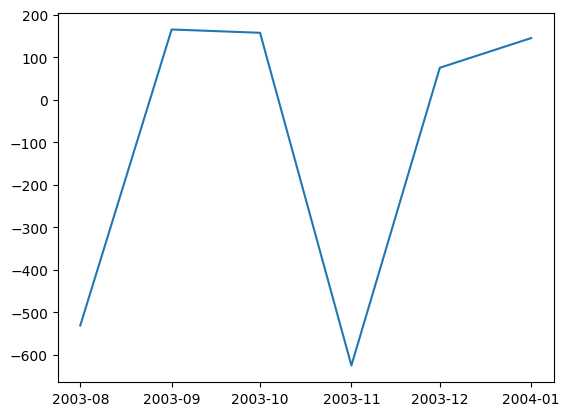

In [104]:
plt.plot(residuals)

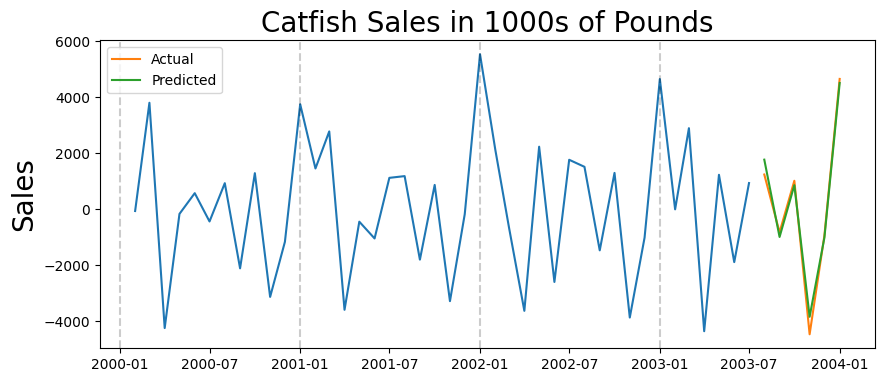

In [105]:
plt.figure(figsize=(10,4))

plt.plot(train_data)

plt.plot(test_data, label='Actual')

plt.plot(predictions_aligned, label='Predicted')

plt.title('Catfish Sales in 1000s of Pounds' , fontsize = 20)

plt.ylabel('Sales' , fontsize = 20)

plt.legend()

for year in range(start_date.year, end_date.year):
    plt.axvline(pd.to_datetime(str(year) + '-01-01'), color='k', linestyle='--', alpha = 0.2)

In [110]:
print(np.mean(abs(residuals/test_data)))

nan


In [109]:
print(np.sqrt(np.mean(residuals**2)))

353.72716992719717
